<a href="https://colab.research.google.com/github/hy0won/-/blob/master/Crime_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [2]:
# basic 
import time
import random
import math

#data analytics
import numpy as np
import pandas as pd

#Math
import scipy as sp
import statsmodels.api as sm

#web crawling
import requests
from bs4 import BeautifulSoup

#visualization
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns

# 브라우저에서 바로 그려지도록 
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
plt.rc('font', family='NanumBarunGothic') 

In [4]:
# Path of the file to read
crime_filepath = "../content/서울시 5대 범죄 발생현황 통계.csv"

# Read the file into a variable spotify_data
crime_data = pd.read_csv(crime_filepath, thousands=',', index_col=False, encoding='CP949')
crime_data = crime_data.set_index('기간')
crime_data.head()

,자치구,합계,합계.1,살인,살인.1,강도,강도.1,강간강제추행,강간강제추행.1,절도,절도.1,폭력,폭력.1
기간,,,,,,,,,,,,,
기간,자치구,발생,검거,발생,검거,발생,검거,발생,검거,발생,검거,발생,검거
2017,합계,"107,835","79,865",142,140,169,170,"6,963","6,558","41,162","21,421","59,399","51,576"
2017,종로구,"4,057","4,437",7,9,10,15,253,"1,412","1,644",905,"2,143","2,096"
2017,중구,"4,184","2,851",1,-,9,9,267,149,"1,846",889,"2,061","1,804"
2017,용산구,"4,060","2,936",1,1,5,4,327,289,"1,346",626,"2,381","2,016"


In [5]:
# 첫번째 행 삭제
crime = crime_data.drop(['기간'])
crime2 = crime[crime['자치구'] == '합계']
crime2 = crime2.loc[:,['합계','합계.1']]
crime_occur=crime2.loc[:,:'합계.1']
crime_occur=crime_occur.rename(columns={"합계":"발생","합계.1":"검거"})
crime_occur

,발생,검거
기간,,
2017,"107,835","79,865"
2018,"101,948","74,487"
2019,"103,668","74,805"
2020,"92,679","66,548"


In [6]:
crime_occur['발생']=crime_occur['발생'].str.replace(',','')
crime_occur['검거']=crime_occur['검거'].str.replace(',','')
crime_occur = crime_occur.astype('int')
crime_occur.dtypes

발생    int64
검거    int64
dtype: object

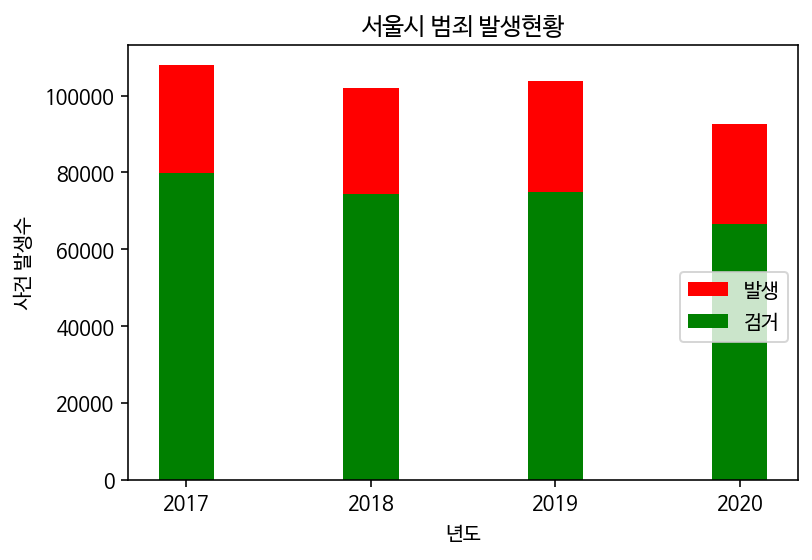

In [7]:
plt.bar(crime_occur.index, crime_occur['발생'], width=0.3, color='red')
plt.bar(crime_occur.index, crime_occur['검거'], width=0.3, color='green')
plt.title('서울시 범죄 발생현황')
plt.xlabel('년도')
plt.ylabel('사건 발생수')
plt.legend(('발생','검거'), loc='upper right', bbox_to_anchor=(1,0.5))
plt.show()

살인 데이터 추출

In [8]:
crime = crime.reset_index()
crime2020 = crime.loc[crime['기간'] == '2020']
crime2020=crime2020.drop(['기간', '합계', '합계.1'], axis=1)
crime2020 = crime2020.set_index('자치구')
crime2020 = crime2020.drop(['합계'])
crime2020.head()

,살인,살인.1,강도,강도.1,강간강제추행,강간강제추행.1,절도,절도.1,폭력,폭력.1
자치구,,,,,,,,,,
종로구,9,7,7,9,192,855,"1,183",944,"1,711","1,528"
중구,2,2,5,6,186,128,"1,642",863,"1,576","1,324"
용산구,5,3,6,6,230,186,"1,111",534,"1,617","1,327"
성동구,5,5,3,3,115,98,"1,016",565,"1,223","1,103"
광진구,2,2,4,4,255,224,"1,664",874,"1,676","1,407"


살인 상위 5곳

In [9]:
m_crime2020 = crime2020.loc[:,['살인']]
m_crime2020['살인']=m_crime2020['살인'].str.replace('-','0')
m_crime2020 = m_crime2020.astype('int')
m_crime2020=m_crime2020.sort_values(by='살인', ascending=False)
m_crime2020.head()

,살인
자치구,
관악구,12
강서구,10
동대문구,10
중랑구,10
종로구,9


각 범죄의 검거율 계산

In [10]:
# 숫자가 문자형으로 처리 되어 있어 문자와 데이터 타입 변경시키기
crime2020 = crime2020.replace(r'-', 0, regex=True)
crime2020 = crime2020.replace(r',', '', regex=True)
crime2020.head()

,살인,살인.1,강도,강도.1,강간강제추행,강간강제추행.1,절도,절도.1,폭력,폭력.1
자치구,,,,,,,,,,
종로구,9,7,7,9,192,855,1183,944,1711,1528
중구,2,2,5,6,186,128,1642,863,1576,1324
용산구,5,3,6,6,230,186,1111,534,1617,1327
성동구,5,5,3,3,115,98,1016,565,1223,1103
광진구,2,2,4,4,255,224,1664,874,1676,1407


In [11]:
crime2020 = crime2020.astype('int')

In [12]:
crime2020['살인검거율'] = crime2020['살인.1']/crime2020['살인']*100
crime2020['강도검거율'] = crime2020['강도.1']/crime2020['강도']*100
crime2020['강간강제추행검거율'] = crime2020['강간강제추행.1']/crime2020['강간강제추행']*100
crime2020['절도검거율'] = crime2020['절도.1']/crime2020['절도']*100
crime2020['폭력검거율'] = crime2020['폭력.1']/crime2020['폭력']*100

# 검거 건수 삭제
del crime2020['살인.1']
del crime2020['강도.1']
del crime2020['강간강제추행.1']
del crime2020['절도.1']
del crime2020['폭력.1']

In [13]:
list = ['살인검거율',	'강도검거율',	'강간강제추행검거율',	'절도검거율',	'폭력검거율']

for column in list:
  crime2020.loc[crime2020[column]>100, column]=100

crime2020.head()

,살인,강도,강간강제추행,절도,폭력,살인검거율,강도검거율,강간강제추행검거율,절도검거율,폭력검거율
자치구,,,,,,,,,,
종로구,9,7,192,1183,1711,77.777778,100.0,100.000000,79.797126,89.304500
중구,2,5,186,1642,1576,100.000000,100.0,68.817204,52.557856,84.010152
용산구,5,6,230,1111,1617,60.000000,100.0,80.869565,48.064806,82.065553
성동구,5,3,115,1016,1223,100.000000,100.0,85.217391,55.610236,90.188062
광진구,2,4,255,1664,1676,100.000000,100.0,87.843137,52.524038,83.949881


In [39]:
crime2020['범죄'] = crime2020['살인']+crime2020['강도']+crime2020['강간강제추행']+crime2020['절도']+crime2020['폭력']
crime2020.head()

,살인,강도,강간강제추행,절도,폭력,살인검거율,강도검거율,강간강제추행검거율,절도검거율,폭력검거율,범죄
자치구,,,,,,,,,,,
종로구,9,7,192,1183,1711,77.777778,100.0,100.000000,79.797126,89.304500,3102
중구,2,5,186,1642,1576,100.000000,100.0,68.817204,52.557856,84.010152,3411
용산구,5,6,230,1111,1617,60.000000,100.0,80.869565,48.064806,82.065553,2969
성동구,5,3,115,1016,1223,100.000000,100.0,85.217391,55.610236,90.188062,2362
광진구,2,4,255,1664,1676,100.000000,100.0,87.843137,52.524038,83.949881,3601


In [43]:
from sklearn import preprocessing

col = ['살인',	'강도',	'강간강제추행',	'절도',	'폭력', '범죄']

x = crime2020[col].values
min_max_scaler = preprocessing.MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(x.astype(float))
crime2020_scaler = pd.DataFrame(x_scaled, columns =  col, index=crime2020.index)

col2 = ['살인검거율',	'강도검거율',	'강간강제추행검거율',	'절도검거율','폭력검거율']
crime2020_scaler[col2] = crime2020[col2]
crime2020_scaler = crime2020_scaler.fillna(0)
crime2020_scaler.head()

,살인,강도,강간강제추행,절도,폭력,범죄,살인검거율,강도검거율,강간강제추행검거율,절도검거율,폭력검거율
자치구,,,,,,,,,,,
종로구,0.750000,0.428571,0.175719,0.185629,0.198859,0.178289,77.777778,100.0,100.000000,79.797126,89.304500
중구,0.166667,0.285714,0.166134,0.397052,0.143847,0.237976,100.000000,100.0,68.817204,52.557856,84.010152
용산구,0.416667,0.357143,0.236422,0.152464,0.160554,0.152598,60.000000,100.0,80.869565,48.064806,82.065553
성동구,0.416667,0.142857,0.052716,0.108706,0.000000,0.035349,100.000000,100.0,85.217391,55.610236,90.188062
광진구,0.166667,0.214286,0.276358,0.407186,0.184597,0.274676,100.000000,100.0,87.843137,52.524038,83.949881


CCTV 파일 데이터 불러오기

In [15]:
# Path of the file to read
cctv_filepath = "../content/방범용 CCTV 현황(201512-202107_연도말기준).xlsx"

# Read the file into a variable spotify_data
cctv_data = pd.read_excel(cctv_filepath, index_col=False)
cctv_data = cctv_data.set_index('구분')
cctv_data.head()

,2015년,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,2016년,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,2019년,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,2020년,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30
구분,,,,,,,,,,,,,,,,,,,,,
종로구,935,762.0,NaN,NaN,NaN,1066,819,33,0.0,0.0,...,1338,1203,41,94,0,1526,1378,39,109,0
중구,363,600.0,NaN,NaN,NaN,565,583,20,NaN,60.0,...,1234,945,69,160,60,1482,1180,75,165,62
용산구,1398,1398.0,NaN,NaN,NaN,1689,1398,175,116.0,0.0,...,1986,1641,202,143,0,2131,1740,237,154,0
성동구,1089,821.0,NaN,NaN,NaN,1328,690,338,NaN,38.0,...,2697,2409,0,161,127,3162,2834,0,177,151
광진구,638,NaN,NaN,NaN,NaN,657,434,209,NaN,72.0,...,2233,1854,240,67,72,2375,1905,301,98,71


In [44]:
# 2020년 cctv 데이터만 가져오기
cctv2020 = cctv_data.loc[:,['2020년']]
cctv=cctv2020.rename(columns={'2020년':'cctv'})
cctv.head()

,cctv
구분,
종로구,1526
중구,1482
용산구,2131
성동구,3162
광진구,2375


In [45]:
crime2020_scaler=crime2020_scaler.join(cctv)
crime2020_scaler.head()

,살인,강도,강간강제추행,절도,폭력,범죄,살인검거율,강도검거율,강간강제추행검거율,절도검거율,폭력검거율,cctv
자치구,,,,,,,,,,,,
종로구,0.750000,0.428571,0.175719,0.185629,0.198859,0.178289,77.777778,100.0,100.000000,79.797126,89.304500,1526
중구,0.166667,0.285714,0.166134,0.397052,0.143847,0.237976,100.000000,100.0,68.817204,52.557856,84.010152,1482
용산구,0.416667,0.357143,0.236422,0.152464,0.160554,0.152598,60.000000,100.0,80.869565,48.064806,82.065553,2131
성동구,0.416667,0.142857,0.052716,0.108706,0.000000,0.035349,100.000000,100.0,85.217391,55.610236,90.188062,3162
광진구,0.166667,0.214286,0.276358,0.407186,0.184597,0.274676,100.000000,100.0,87.843137,52.524038,83.949881,2375


범죄와 cctv의 상관 관계 시각화

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


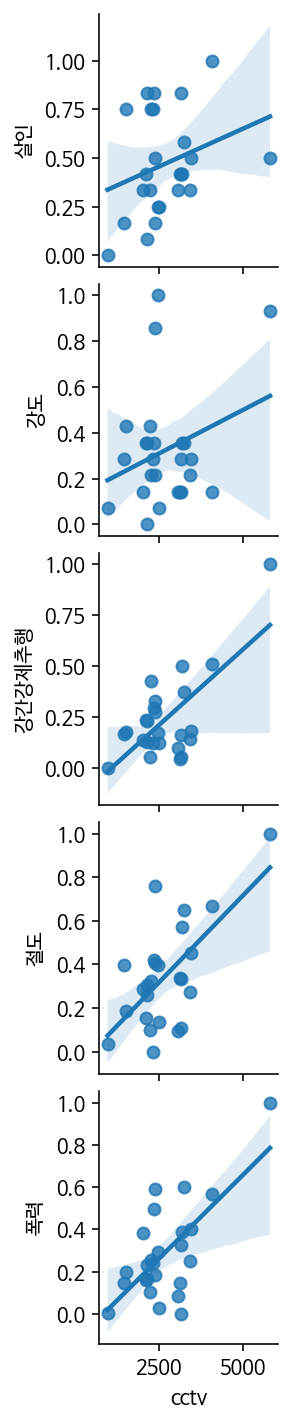

In [46]:
# 사건 발생과 cctv의 상관관계
sns.pairplot(crime2020_scaler, x_vars=['cctv'], y_vars=['살인', '강도',	'강간강제추행',	'절도',	'폭력'],
             kind='reg', size=2)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


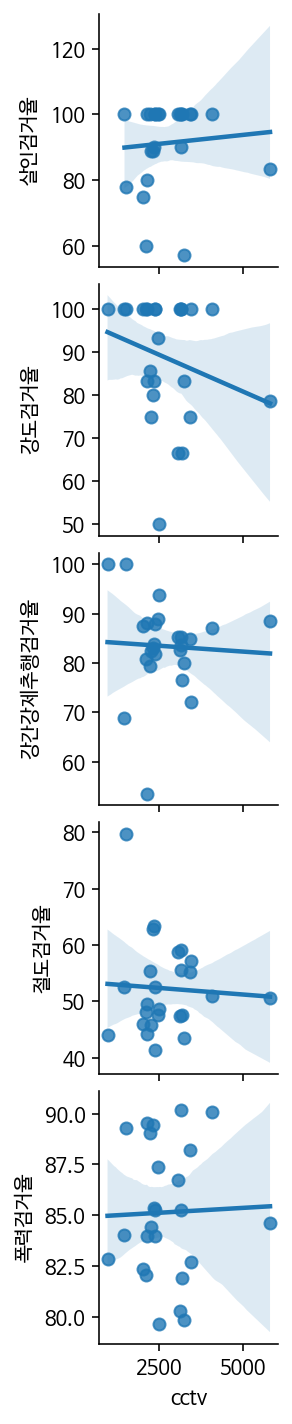

In [20]:
# 검거와 cctv의 상관관계

sns.pairplot(crime2020_scaler, x_vars=['cctv'], y_vars=['살인검거율',	'강도검거율',	'강간강제추행검거율',	'절도검거율',	'폭력검거율'	],
             kind='reg', size=2)

In [48]:
crime2020_scaler=crime2020_scaler.sort_values(by='범죄', ascending=False)

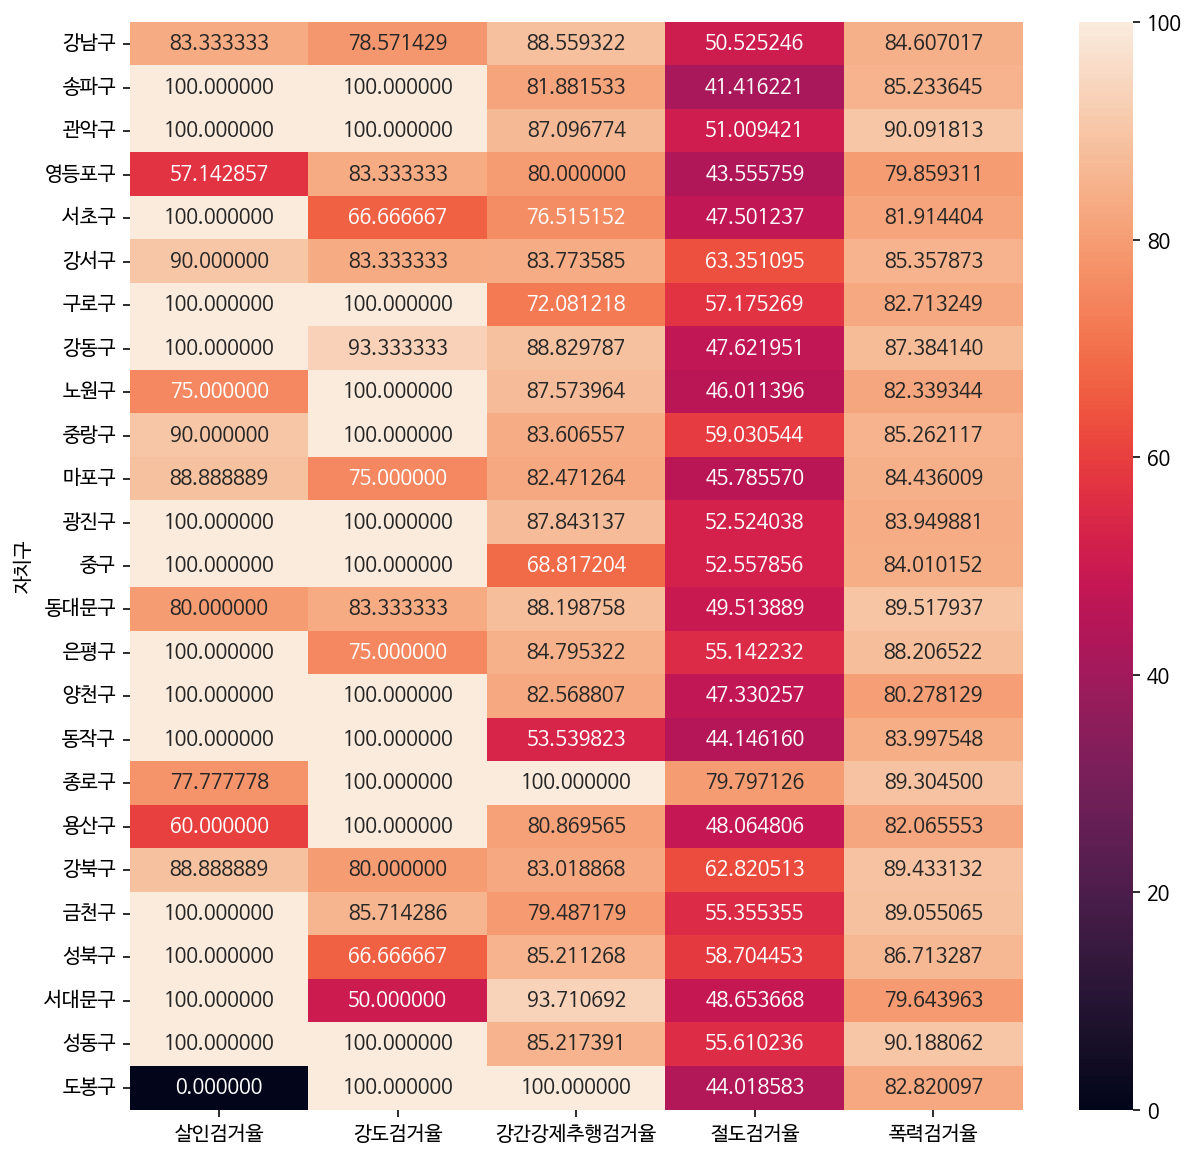

In [49]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(crime2020_scaler.loc[:,['살인검거율',	'강도검거율',	'강간강제추행검거율',	'절도검거율',	'폭력검거율']], annot=True, fmt='f')

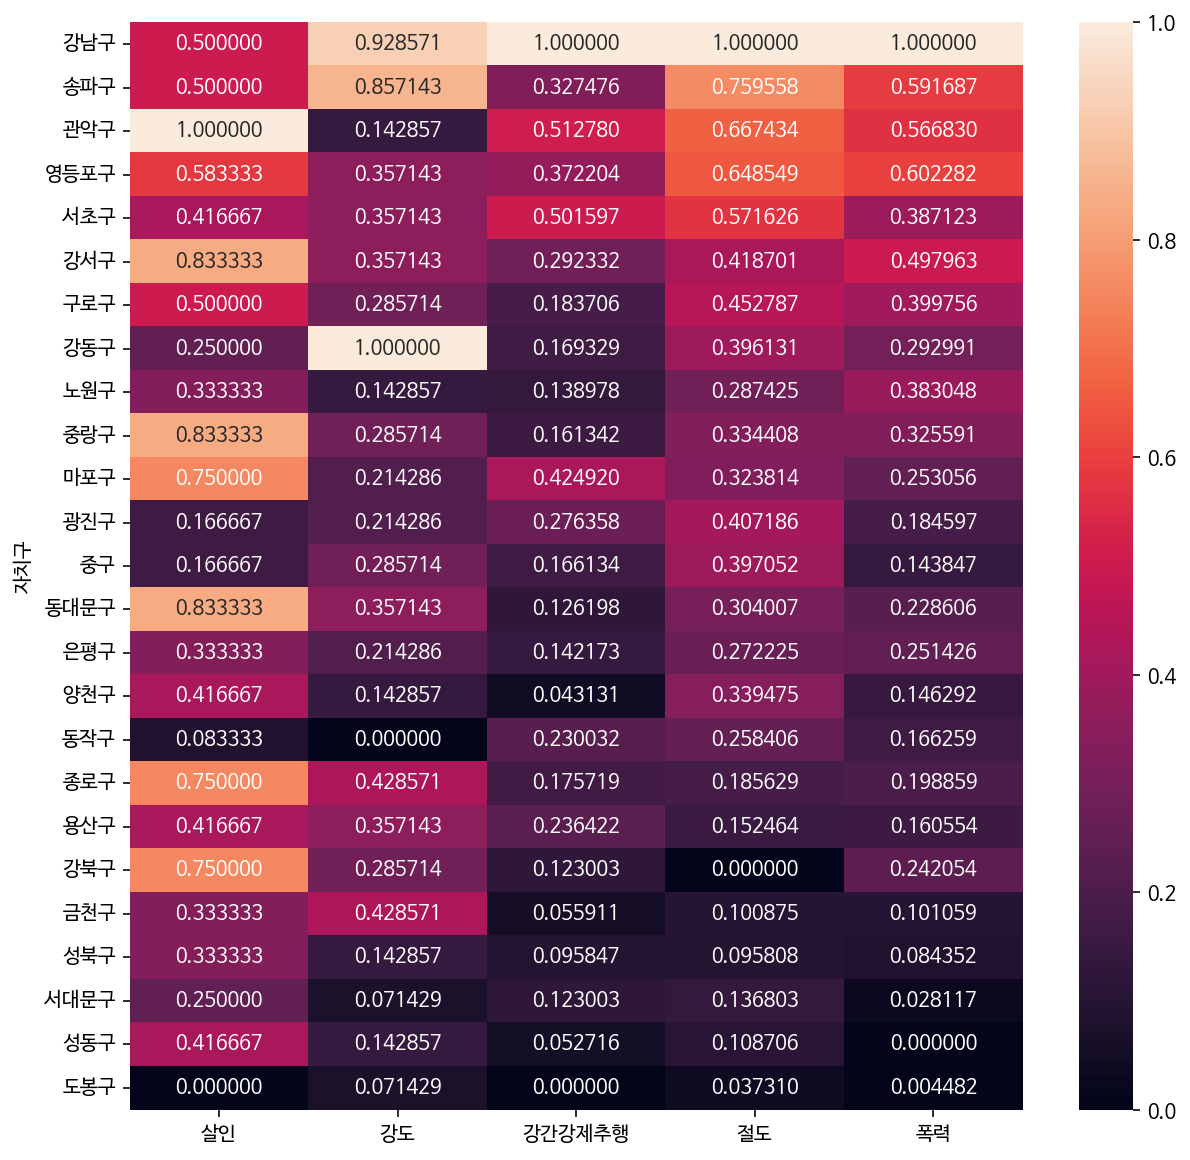

In [50]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(crime2020_scaler.loc[:,['살인', '강도',	'강간강제추행',	'절도',	'폭력']], annot=True, fmt='f')